### In this notebook, we evaluate the ability of different text encoders to identify:

1- Semantically similar captions across multiple languages \
2- Semantically similar English captions

### We evaluate:

1- Text encoders pretrained to discriminate images (CLIP ViT-L and ViT-B) \
2- Text encoders pretrained to align semantically similar text (both English and multilingual))

In [18]:
%run language_similarity.py
%matplotlib inline

from language_similarity import *

<Figure size 640x480 with 0 Axes>

In [19]:
# Create directory to save plots
import os
os.makedirs("plots")

## Semantically similar captions across multiple languages (English, French and Italian)

1- Generate three sentences in english and translate them in french and italian.  \
2- Use text encoder from (VLM or LM) to embed sentences \ 
3- Compute cosine similarity between all embeddings \

Expected Output:

A text encoder with good understanding of english, french and italian will project semantically identical sentences from different languages close to each other in the embedding space while pushing away sematically different sentences from all languages. 

In [20]:
description = { # Phrase one
               "english1": "this man is tall", 
               "french1":"cet homme est grand", 
               "italian1": "quest'uomo è alto",
               # Phrase two
               "english2": "a photo of a building next to a car", 
               "french2": "une photo d'un bâtiment à côté d'une voiture",   
               "italian2": "una foto di un edificio accanto a un'auto",
               # Phrase three
               "english3": "a bottle of water",
               "french3": "une bouteille d'eau",
               "italian3": "una bottiglia d'acqua"
               }


labels = ["english1", "french1", "italian1",
          "english2", "french2", "italian2",
          "english3", "french3", "italian3"]


captions = ["this man is tall", "cet homme est grand", "quest'uomo è alto",
                "a photo of a building next to a car", "une photo d'un bâtiment à côté d'une voiture", "una foto di un edificio accanto a un'auto",
                 "a bottle of water", "une bouteille d'eau","una bottiglia d'acqua"]



### **CLIP ViT-L** (Vision-Language Model)

{ \
    "embed_dim": 768,\
    "vision_cfg": {\
        "image_size": 224,\
        "layers": 24,\
        "width": 1024,\
        "patch_size": 14\
    },\
    "text_cfg": {\
        "context_length": 77,\
        "vocab_size": 49408,\
        "width": 768,\
        "heads": 12,\
        "layers": 12\
    }\
}

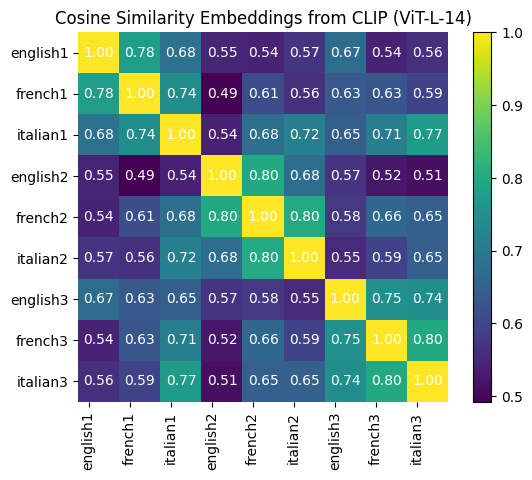

In [21]:
## Initialize CLIP from open CLIP
model_name = 'ViT-L-14'
clip_model, tokenizer = initialize_clip(model_name)
text_tokens = torch.stack([tokenizer(cap)[0] for cap in captions], dim=0)
text_tokens = text_tokens.to(device)
similarity = get_similarity(clip_model, text_tokens)
plt = plot_heatmap(similarity, labels, model_name=f'Cosine Similarity Embeddings from CLIP ({model_name})')

plt.savefig("plots/cosine_similarity_multi_clip_large.pdf", bbox_inches="tight", format="pdf")

Comment: The 3x3 diagonal submatrices are mostly higher than the off-diagonal elements. This indicates that CLIP ViT text encoder has a decent understanding of same concept in different languages. 

### **CLIP ViT-B** (Vision-Language Model)

{ \
    "embed_dim": 512, \
    "vision_cfg": { \
        "image_size": 224,\
        "layers": 12,\
        "width": 768,\
        "patch_size": 32\
    },\
    "text_cfg": {\
        "context_length": 77,\
        "vocab_size": 49408,\
        "width": 512,\
        "heads": 8,\
        "layers": 12\
    }\
}

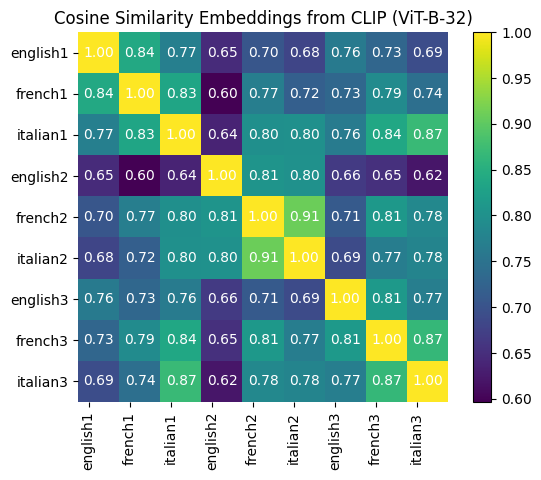

In [22]:
## Initialize CLIP from open CLIP
model_name = 'ViT-B-32'
clip_model, tokenizer = initialize_clip(model_name)
text_tokens = torch.stack([tokenizer(cap)[0] for cap in captions], dim=0)
text_tokens = text_tokens.to(device)
similarity = get_similarity(clip_model, text_tokens)
plt = plot_heatmap(similarity, labels, model_name=f'Cosine Similarity Embeddings from CLIP ({model_name})')

plt.savefig("plots/cosine_similarity_multi_clip_base.pdf", bbox_inches="tight", format="pdf")

Comment: The 3x3 diagonal submatrices are mostly higher than the off-diagonal elements. However, the separation in terms of cosine similarity between the diagonal elements and off-diagonal elements of ViT-B text encoder is not as large as the separation we observe in CLIP ViT-L text encoder. This demonstrates that CLIP-L text encoder learns embeddings that provide better semantic clustering with respect to langauge. 

### **all-MiniLM-L6-v2** (Language Model trained only on english)

Note: This is the model we use for embedding text from image-text pairs and text from generated samples

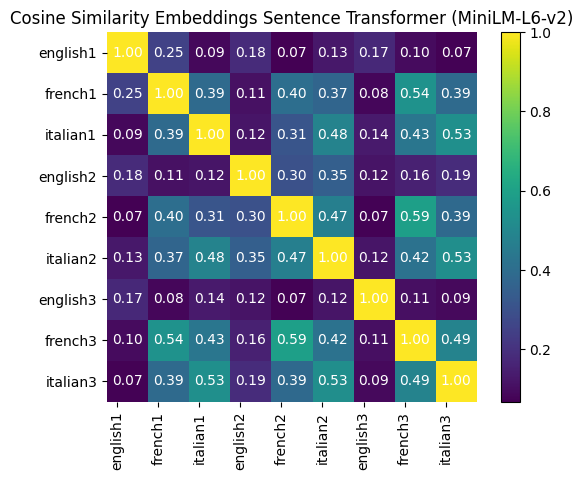

In [23]:
model_name = 'MiniLM-L6-v2'
sen_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').to(device)
sen_model.eval()
sentence_embeddings = sen_model.encode(captions, convert_to_tensor=True)
sentence_embeddings /= sentence_embeddings.norm(dim=1, keepdim=True)
similarity = sentence_embeddings.cpu().numpy() @ sentence_embeddings.cpu().numpy().T
plt = plot_heatmap(similarity, labels, model_name=f'Cosine Similarity Embeddings Sentence Transformer ({model_name})')

plt.savefig("plots/cosine_similarity_multi_sentence_transformer.pdf", bbox_inches="tight", format="pdf")

Comment: As expected, the language model we use is only trained on english text. Therefore, it confuse french with italian in group 1, 2 and 3. the off-diagonal cosine similarities are as high as the diagonal elements, indicating that the embedding space isnt useful for comparing sentences in different languages. 

### **distiluse-base-multilingual-cased-v1** (Language Model trained on multiple languages)

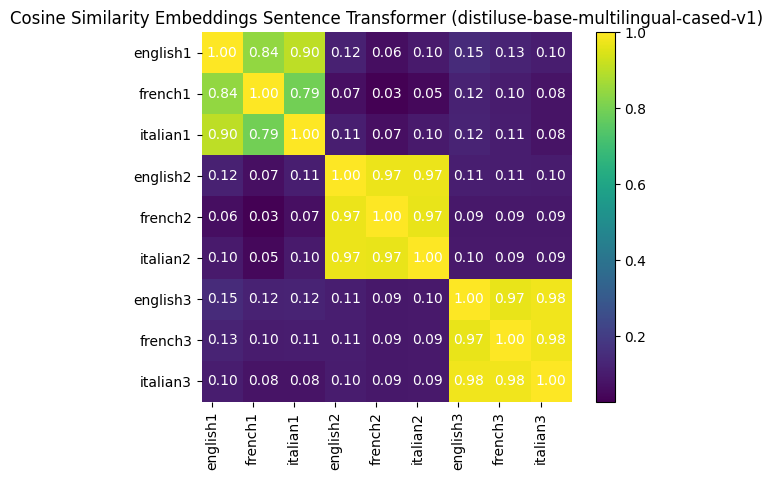

In [24]:
model_name = 'distiluse-base-multilingual-cased-v1'
sen_model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v1').to(device)
sen_model.eval()
sentence_embeddings = sen_model.encode(captions, convert_to_tensor=True)
sentence_embeddings /= sentence_embeddings.norm(dim=1, keepdim=True)
similarity = sentence_embeddings.cpu().numpy() @ sentence_embeddings.cpu().numpy().T
plt = plot_heatmap(similarity, labels, model_name=f'Cosine Similarity Embeddings Sentence Transformer ({model_name})')

plt.savefig("plots/cosine_similarity_multi_multilingual_sentence_transformer.pdf", bbox_inches="tight", format="pdf")

Comment: This sentence similarity language model is trained on multiple langauges. This is a clear separation between diagonal submatrices and off-diagonal ones. This embedding space is ideal for comparing sentences from different languages.

## Semantically similar English captions

1- Generate three sets/groups of sentences with similar objects/meaning  \
2- Use text encoder from (VLM or LM) to embed sentences \ 
3- Compute cosine similarity between all embeddings \

Expected Output:

A text encoder with good semantic understanding should cluster semantically similar sentences (sentences in the same group) together while semantically different sentences should be clustered far away.

In [25]:
labels = ["group11", "group12", "group13",
          "group21", "group22", "group23",
          "group31", "group32", "group33",]


captions = ["a dog and a cat", "a dog running after a cat", "a cat next to a dog",
            "a sports car", "a black parked vehicle", "can you drive this car?",
                 "a table next to a chair", "a desk and chair","a standing desk"]

### **CLIP ViT-L** (Vision-Language Model)

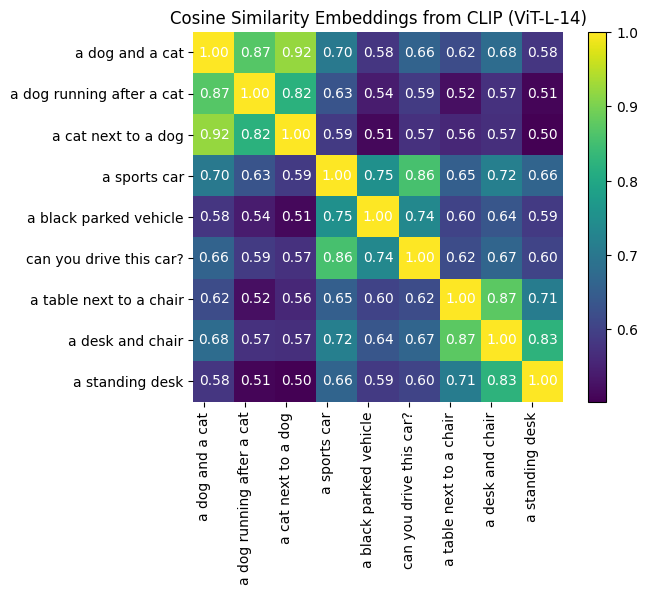

In [26]:
## Initialize CLIP from open CLIP
model_name = 'ViT-L-14'
clip_model, tokenizer = initialize_clip(model_name)
text_tokens = torch.stack([tokenizer(cap)[0] for cap in captions], dim=0)
text_tokens = text_tokens.to(device)
similarity = get_similarity(clip_model, text_tokens)
plt = plot_heatmap(similarity, captions, model_name=f'Cosine Similarity Embeddings from CLIP ({model_name})')

plt.savefig("plots/cosine_similarity_english_clip_large.pdf", bbox_inches="tight", format="pdf")

Comment: CLIP large text encoder has a decent ability to detect similar gorups, however as we observe the diagonal elements of group 2 and 3 are pretty high even though the two group discuss two different environments/concepts. 

### **CLIP-B** (Vision-Language Model)

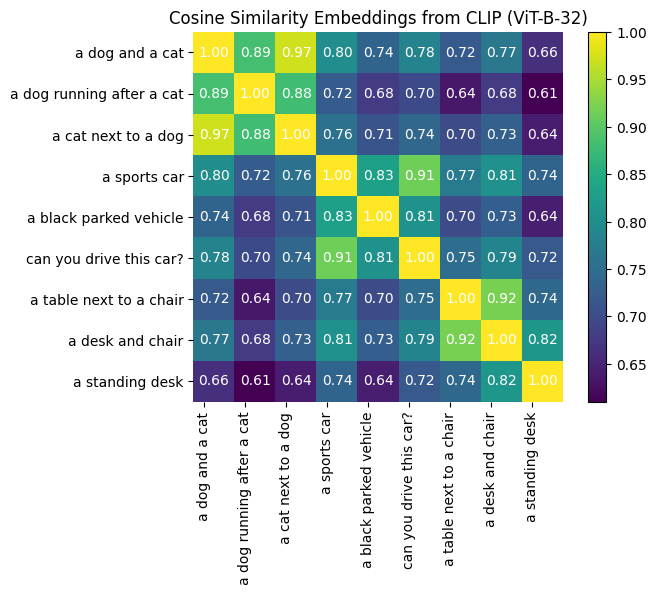

In [27]:
## Initialize CLIP from open CLIP
model_name = 'ViT-B-32'
clip_model, tokenizer = initialize_clip(model_name)
text_tokens = torch.stack([tokenizer(cap)[0] for cap in captions], dim=0)
text_tokens = text_tokens.to(device)
similarity = get_similarity(clip_model, text_tokens)
plt = plot_heatmap(similarity, captions, model_name=f'Cosine Similarity Embeddings from CLIP ({model_name})')

plt.savefig("plots/cosine_similarity_english_clip_base.pdf", bbox_inches="tight", format="pdf")

Comment: Using CLIP ViT-B text encoder shows the same behavior as CLIP ViT-L but the separation between different groups is less distinct. 

### **BLIP-14M** (Image Caption Generator)

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_14M.pth


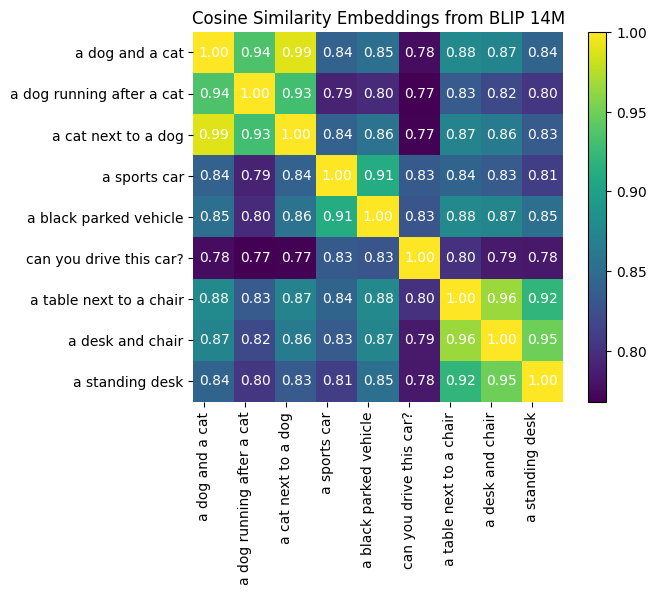

In [28]:
## Load BLIP text encoder
model_name = 'model_base_14M'
blip_model = initialize_blip(model_name)
text_features = blip_model(image=None,
                           caption=captions,
                           match_head='return_text_features',
                           device_to_use='cpu')
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.detach().numpy() @ text_features.detach().numpy().T
plt = plot_heatmap(similarity, captions, model_name=f'Cosine Similarity Embeddings from BLIP 14M')

plt.savefig("plots/cosine_similarity_english_blip14m.pdf", bbox_inches="tight", format="pdf")

### **all-MiniLM-L6-v2** (Language Model trained only on **English**)

Note: This is the model we use for embedding text from image-text pairs and text from generated samples

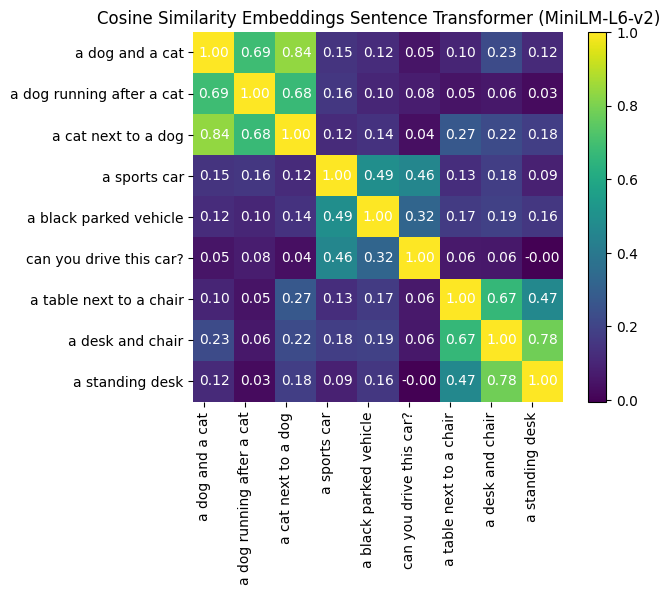

In [29]:
model_name = 'MiniLM-L6-v2'
sen_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').to(device)
sen_model.eval()
sentence_embeddings = sen_model.encode(captions, convert_to_tensor=True)
sentence_embeddings /= sentence_embeddings.norm(dim=1, keepdim=True)
similarity = sentence_embeddings.cpu().numpy() @ sentence_embeddings.cpu().numpy().T
plt = plot_heatmap(similarity, captions, model_name=f'Cosine Similarity Embeddings Sentence Transformer ({model_name})')

plt.savefig("plots/cosine_similarity_english_sentence_transformer.pdf", bbox_inches="tight", format="pdf")

### **distiluse-base-multilingual-cased-v1** (Language Model trained on **multiple** languages)

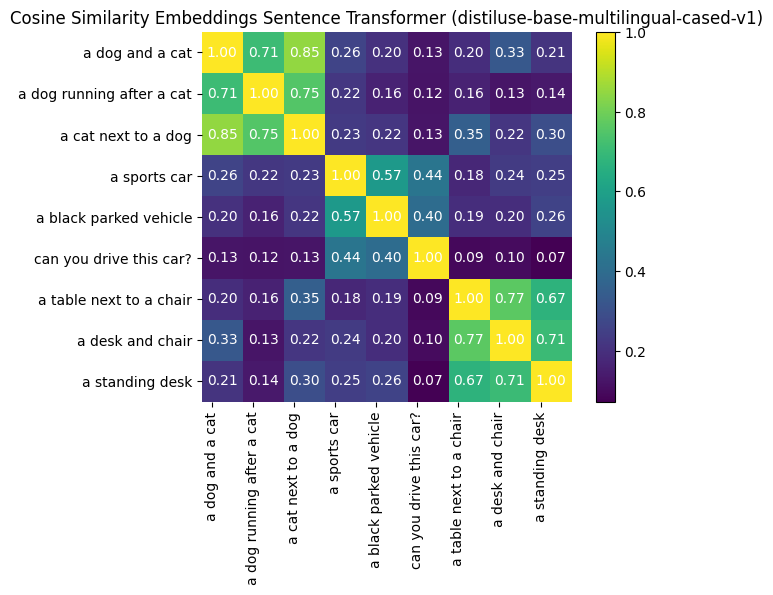

In [30]:
model_name = 'distiluse-base-multilingual-cased-v1'
sen_model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v1').to(device)
sen_model.eval()
sentence_embeddings = sen_model.encode(captions, convert_to_tensor=True)
sentence_embeddings /= sentence_embeddings.norm(dim=1, keepdim=True)
similarity = sentence_embeddings.cpu().numpy() @ sentence_embeddings.cpu().numpy().T
plt = plot_heatmap(similarity, captions, model_name=f'Cosine Similarity Embeddings Sentence Transformer ({model_name})')

plt.savefig("plots/cosine_similarity_english_multilingual_sentence_transformer.pdf", bbox_inches="tight", format="pdf")

Comment: Compared to CLIP text encoders, both sentence similarity models (trained only on English and trained on multiple langauges) show much better inter-cluster and intra-cluster cosine similarity values. 

In [31]:
labels = ["group11", "group12", "group13",
          "group21", "group22", "group23",
          "group31", "group32", "group33",]


captions = ["an image of a dog and a cat", "an image of a dog running after a cat", "an image of a cat next to a dog",
            "an image of a sports car", "an image of a black parked vehicle", "an image of can you drive this car?",
                 "an image of a table next to a chair", "an image of a desk and chair","an image of a standing desk"]

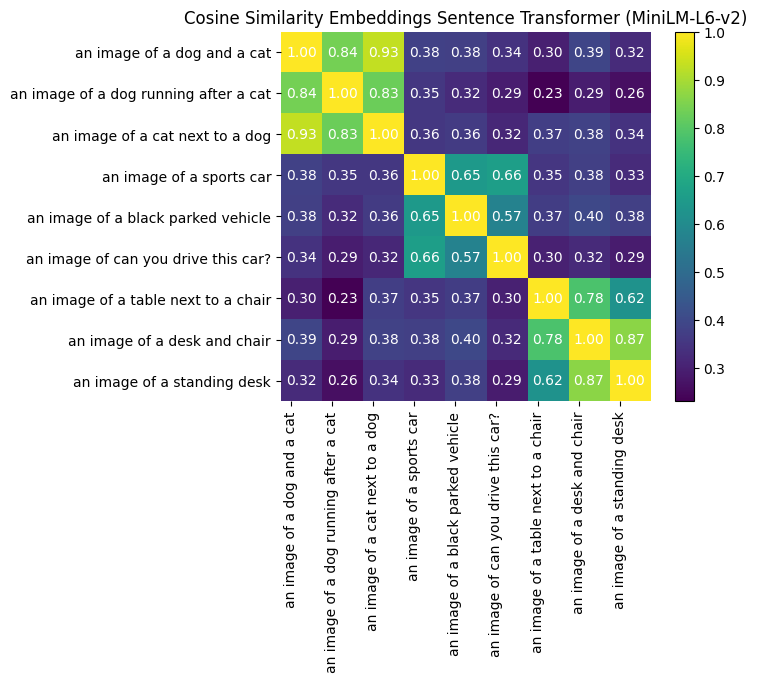

In [32]:
model_name = 'MiniLM-L6-v2'
sen_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').to(device)
sen_model.eval()
sentence_embeddings = sen_model.encode(captions, convert_to_tensor=True)
sentence_embeddings /= sentence_embeddings.norm(dim=1, keepdim=True)
similarity = sentence_embeddings.cpu().numpy() @ sentence_embeddings.cpu().numpy().T
plt = plot_heatmap(similarity, captions, model_name=f'Cosine Similarity Embeddings Sentence Transformer ({model_name})')

plt.savefig("plots/cosine_similarity_medium_sentence_transformer.pdf", bbox_inches="tight", format="pdf")

In [33]:
labels = ["group11", "group12", "group13",
          "group21", "group22", "group23",
          "group31", "group32", "group33",]


captions = ["an image of a dog and a cat", "a dog running after a cat", "a cat next to a dog",
            "an image of a sports car", "a black parked vehicle", "can you drive this car?",
                 "an image of a table next to a chair", "a desk and chair","a standing desk"]

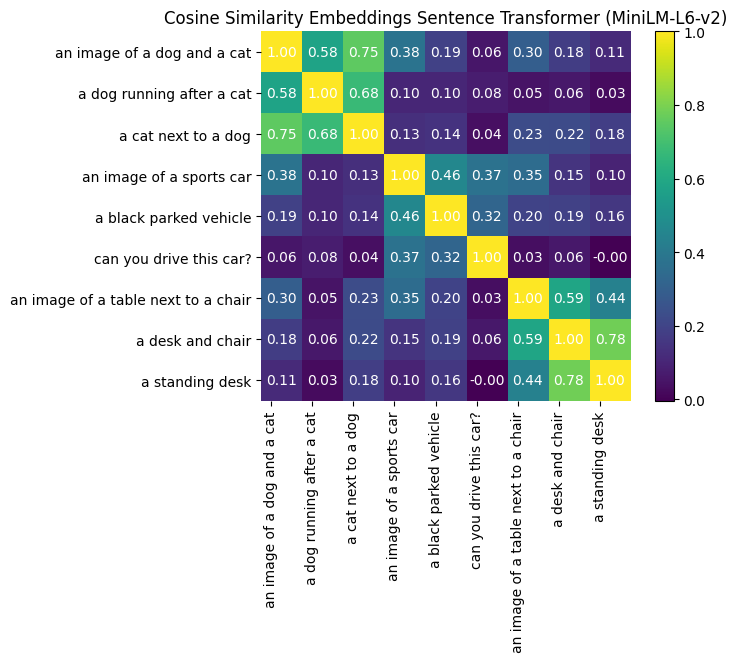

In [34]:
model_name = 'MiniLM-L6-v2'
sen_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').to(device)
sen_model.eval()
sentence_embeddings = sen_model.encode(captions, convert_to_tensor=True)
sentence_embeddings /= sentence_embeddings.norm(dim=1, keepdim=True)
similarity = sentence_embeddings.cpu().numpy() @ sentence_embeddings.cpu().numpy().T
plt = plot_heatmap(similarity, captions, model_name=f'Cosine Similarity Embeddings Sentence Transformer ({model_name})')

plt.savefig("plots/cosine_similarity_mask_sentence_transformer.pdf", bbox_inches="tight", format="pdf")